In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset, build_categorical_prep


/Users/antonsruberts/miniconda/envs/blog/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 15})

## Download Data

In [3]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=CSV_HEADER)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [4]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess

In [5]:
# Column information
NUMERIC_FEATURES = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']

FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)
LABEL = 'income_bracket'

In [6]:
# encoding as binary target
train_data[LABEL] = train_data[LABEL].apply(lambda x: int(x == ' >50K')) 
test_data[LABEL] = test_data[LABEL].apply(lambda x: int(x == ' >50K.'))
train_data[LABEL].mean(), test_data[LABEL].mean()

(0.2408095574460244, 0.23621176759611842)

In [7]:
test_data = test_data.iloc[1:, :] # drop invalid row

In [8]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [9]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [10]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

## Modelling Prep

In [11]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

/Users/antonsruberts/personal/TabTransformerTF/tabtransformertf/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
2022-11-18 18:30:27.535732: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/antonsruberts/personal/TabTransformerTF/tabtransformertf/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/Users/antonsruberts/persona

# FTTransformer

## FT Transformer - Linear Numerical Encoding

In [12]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = None,
    numerical_embedding_type='linear',
    embedding_dim=16,
    depth=4,
    heads=8,
    attn_dropout=0.2,
    ff_dropout=0.2,
    explainable=True
)

# Pass the encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation='sigmoid',
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 1000

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.BinaryCrossentropy(), "importances": None},
    metrics= {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/1000
51/51 [==============================] - 16s 195ms/step - loss: 0.3909 - output_loss: 0.3909 - output_PR AUC: 0.6437 - val_loss: 0.3460 - val_output_loss: 0.3460 - val_output_PR AUC: 0.7198
Epoch 2/1000
51/51 [==============================] - 9s 179ms/step - loss: 0.3376 - output_loss: 0.3376 - output_PR AUC: 0.7224 - val_loss: 0.3369 - val_output_loss: 0.3369 - val_output_PR AUC: 0.7364
Epoch 3/1000
51/51 [==============================] - 9s 174ms/step - loss: 0.3272 - output_loss: 0.3272 - output_PR AUC: 0.7414 - val_loss: 0.3302 - val_output_loss: 0.3302 - val_output_PR AUC: 0.7458
Epoch 4/1000
51/51 [==============================] - 9s 175ms/step - loss: 0.3262 - output_loss: 0.3262 - output_PR AUC: 0.7452 - val_loss: 0.3278 - val_output_loss: 0.3278 - val_output_PR AUC: 0.7507
Epoch 5/1000
51/51 [==============================] - 11s 204ms/step - loss: 0.3230 - output_loss: 0.3230 - output_PR AUC: 0.7517 - val_loss: 0.3236 - val_output_loss: 0.3236 - val_output_PR 

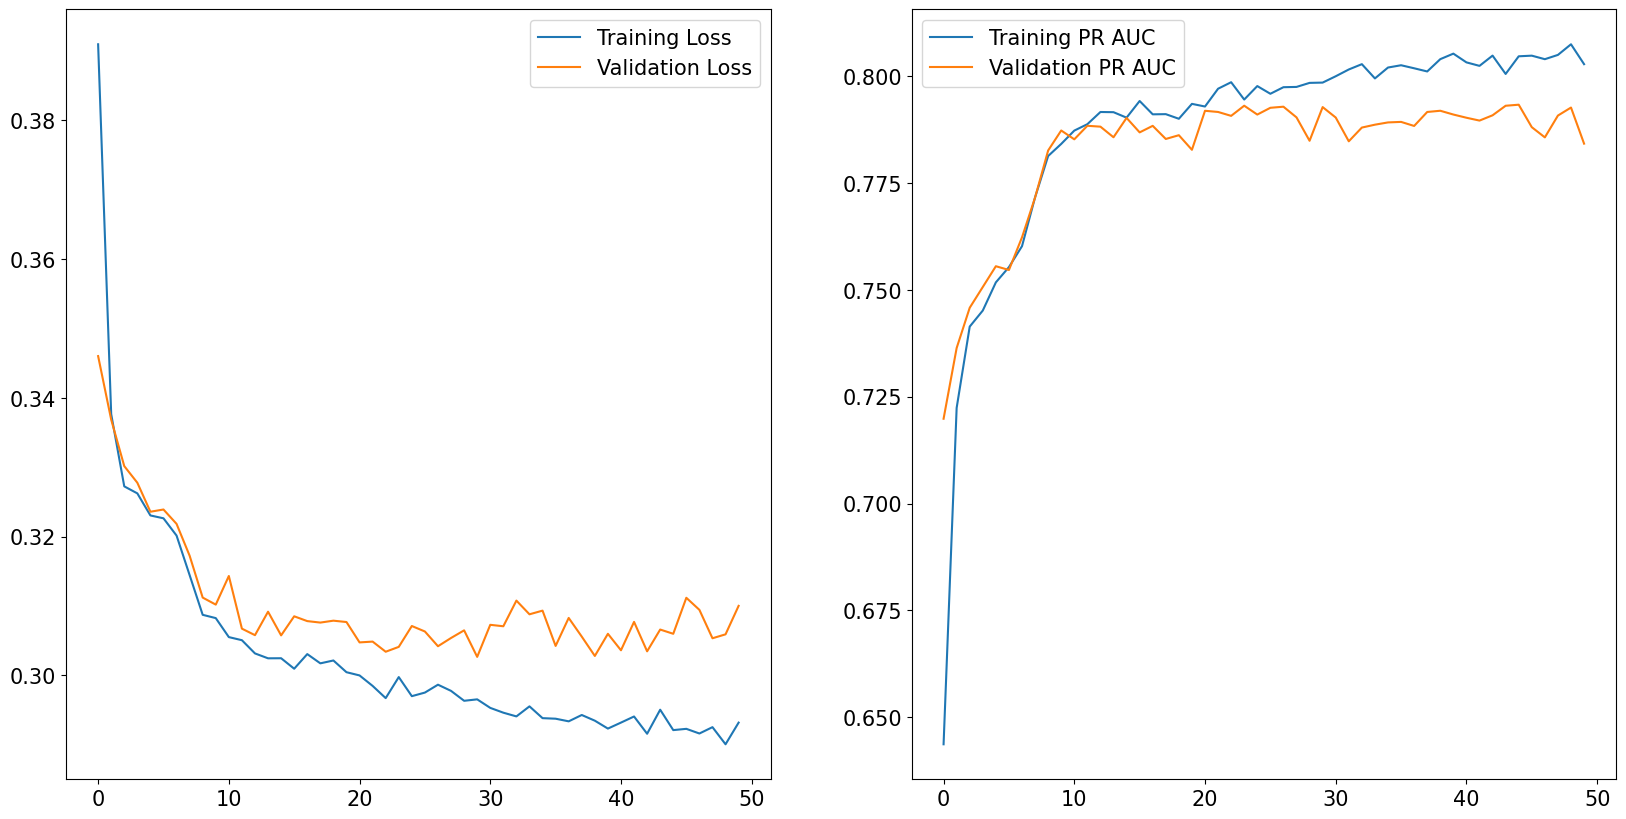

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(ft_linear_history.history['loss'], label='Training Loss')
ax[0].plot(ft_linear_history.history['val_loss'], label='Validation Loss')
ax[0].legend()

ax[1].plot(ft_linear_history.history['output_PR AUC'], label='Training PR AUC')
ax[1].plot(ft_linear_history.history['val_output_PR AUC'], label='Validation PR AUC')
ax[1].legend()

plt.show()

In [15]:
linear_test_preds = ft_linear_transformer.predict(test_dataset)
print("FT-Transformer with Linear Numerical Embedding")
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], linear_test_preds['output'].ravel()), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], linear_test_preds['output'].ravel()), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], linear_test_preds['output'].ravel()>0.5), 4))

# Reported accuracy - 0.858

FT-Transformer with Linear Numerical Embedding
Test ROC AUC: 0.9118
Test PR AUC: 0.7842
Test Accuracy: 0.8577


## Explainability

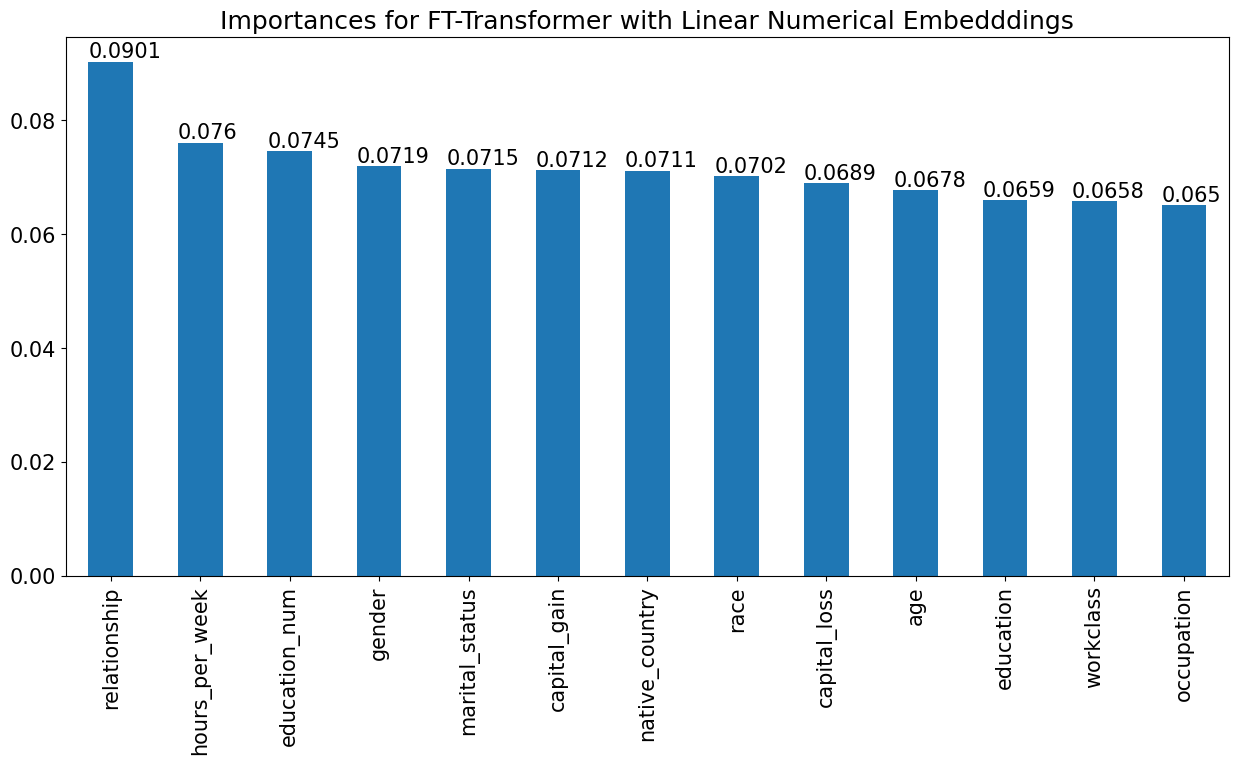

In [17]:
linear_importances = linear_test_preds['importances']
linear_importances_df = pd.DataFrame(linear_importances[:, :-1], columns = FEATURES)
linear_total_importances = get_model_importances(
    linear_importances_df, title="Importances for FT-Transformer with Linear Numerical Embedddings"
)

In [50]:
# Largest prediction
max_idx = np.argsort(linear_test_preds['output'].ravel())[-1]
example_importance_linear = linear_importances_df.iloc[max_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
    test_data.iloc[max_idx, :].rename("Example Vlaue")
).head(5)
print(f"Top 5 contributions to row {max_idx} which was scored {str(np.round(linear_test_preds['output'].ravel()[max_idx], 4))}")
display(example_importance_linear)

# Smallest one
min_idx = np.argsort(linear_test_preds['output'].ravel())[0]
example_importance_linear = linear_importances_df.iloc[min_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
    test_data.iloc[min_idx, :].rename("Example Vlaue")
).head(5)
print(f"Top 5 contributions to row {min_idx} which was scored {str(np.round(linear_test_preds['output'].ravel()[min_idx], 4))}")
display(example_importance_linear)

Top 5 contributions to row 3608 which was scored 0.9919


,Importance,Example Vlaue
gender,0.164829,Female
age,0.076485,1.355023
capital_loss,0.072796,-0.216317
occupation,0.072420,Prof-specialty
relationship,0.071956,Wife


Top 5 contributions to row 12682 which was scored 0.0016


,Importance,Example Vlaue
relationship,0.099172,Other-relative
occupation,0.086154,Transport-moving
hours_per_week,0.081941,-0.037162
capital_gain,0.070829,-0.143609
education_num,0.069647,-3.146201
